# Phase 4: Model Validation and Analysis

This notebook performs comprehensive validation of the trained models including:
- Regional performance analysis
- Crop-specific analysis
- Error analysis and diagnostics
- Classification metrics (Accuracy, Precision, Recall, F1-score)
- SHAP-based feature importance analysis

---
## Setup and Imports

In [1]:
# Pre-flight checks
import os
from pathlib import Path

print("="*80)
print("PRE-FLIGHT CHECKS")
print("="*80)

# Check project structure
models_dir = Path('models')
data_path = Path('project_data')
splits_path = data_path / 'train_test_split'

print("\n📁 Directory Structure:")
print(f"  models/ exists: {models_dir.exists()}")
print(f"  project_data/ exists: {data_path.exists()}")
print(f"  train_test_split/ exists: {splits_path.exists()}")

# Check model files
print("\n🤖 Model Files:")
model_files = ['fnn_model.keras', 'lstm_model.keras', 'hybrid_model.keras']
for mf in model_files:
    exists = (models_dir / mf).exists()
    symbol = "✓" if exists else "✗"
    print(f"  {symbol} {mf}: {exists}")

# Check scaler files
print("\n📊 Scaler Files:")
scaler_files = ['fnn_scaler.pkl', 'lstm_scaler.pkl', 'hybrid_temp_scaler.pkl', 'hybrid_stat_scaler.pkl']
for sf in scaler_files:
    exists = (models_dir / sf).exists()
    symbol = "✓" if exists else "✗"
    print(f"  {symbol} {sf}: {exists}")

# Check encoder files
print("\n🔢 Encoder Files:")
encoder_files = ['le_crop.pkl', 'le_zone.pkl', 'le_state.pkl']
for ef in encoder_files:
    exists = (models_dir / ef).exists()
    symbol = "✓" if exists else "✗"
    print(f"  {symbol} {ef}: {exists}")

# Check test data
print("\n📋 Test Data Files:")
test_files = [
    ('fnn/test.csv', splits_path / 'fnn' / 'test.csv'),
    ('lstm/test.csv', splits_path / 'lstm' / 'test.csv'),
    ('hybrid/test.csv', splits_path / 'hybrid' / 'test.csv')
]
for name, path in test_files:
    exists = path.exists()
    symbol = "✓" if exists else "✗"
    print(f"  {symbol} {name}: {exists}")

print("\n" + "="*80)
print("✓ Pre-flight checks complete!")
print("="*80)

PRE-FLIGHT CHECKS

📁 Directory Structure:
  models/ exists: True
  project_data/ exists: True
  train_test_split/ exists: True

🤖 Model Files:
  ✓ fnn_model.keras: True
  ✓ lstm_model.keras: True
  ✓ hybrid_model.keras: True

📊 Scaler Files:
  ✓ fnn_scaler.pkl: True
  ✓ lstm_scaler.pkl: True
  ✓ hybrid_temp_scaler.pkl: True
  ✓ hybrid_stat_scaler.pkl: True

🔢 Encoder Files:
  ✓ le_crop.pkl: True
  ✓ le_zone.pkl: True
  ✓ le_state.pkl: True

📋 Test Data Files:
  ✓ fnn/test.csv: True
  ✓ lstm/test.csv: True
  ✓ hybrid/test.csv: True

✓ Pre-flight checks complete!


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Scikit-learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

# Model interpretation (safe import + install fallback)
try:
    import shap
except Exception as e:
    print("shap import failed:", e)
    print("Attempting to install shap into the current Python environment...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import importlib
    shap = importlib.import_module("shap")
    print("shap installed and imported")

# Utilities
import joblib

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


---
## Load Trained Models and Data

In [3]:
# Define paths
models_dir = Path('models')
data_path = Path('project_data')
splits_path = data_path / 'train_test_split'

print("Loading trained models...")

# Load models
fnn_model = keras.models.load_model(models_dir / 'fnn_model.keras')
lstm_model = keras.models.load_model(models_dir / 'lstm_model.keras')
hybrid_model = keras.models.load_model(models_dir / 'hybrid_model.keras')

print("  ✓ Models loaded")

# Load scalers
fnn_scaler = joblib.load(models_dir / 'fnn_scaler.pkl')
lstm_scaler = joblib.load(models_dir / 'lstm_scaler.pkl')
hybrid_temp_scaler = joblib.load(models_dir / 'hybrid_temp_scaler.pkl')
hybrid_stat_scaler = joblib.load(models_dir / 'hybrid_stat_scaler.pkl')

print("  ✓ Scalers loaded")

# Load encoders
le_crop = joblib.load(models_dir / 'le_crop.pkl')
le_zone = joblib.load(models_dir / 'le_zone.pkl')
le_state = joblib.load(models_dir / 'le_state.pkl')

print("  ✓ Encoders loaded")

Loading trained models...
  ✓ Models loaded
  ✓ Scalers loaded
  ✓ Encoders loaded


In [4]:
# Load test data
print("\nLoading test datasets...")

fnn_test = pd.read_csv(splits_path / 'fnn' / 'test.csv')
lstm_test = pd.read_csv(splits_path / 'lstm' / 'test.csv')
hybrid_test = pd.read_csv(splits_path / 'hybrid' / 'test.csv')

# Remove missing yields
fnn_test = fnn_test.dropna(subset=['Yield_tonnes_per_ha'])
lstm_test = lstm_test.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_test = hybrid_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"  FNN test: {fnn_test.shape}")
print(f"  LSTM test: {lstm_test.shape}")
print(f"  Hybrid test: {hybrid_test.shape}")


Loading test datasets...
  FNN test: (432, 33)
  LSTM test: (5184, 38)
  Hybrid test: (5184, 41)


---
## 1. Regional Performance Analysis

### 1.1 Generate Predictions with Metadata

In [5]:
# Prepare FNN predictions with metadata
print("Generating FNN predictions...")

# Define FNN features (same as Phase 3)
fnn_feature_cols = [
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C', 'Temp_Range_C',
    'Rainfall_mm', 'Rainy_Days', 'Max_Daily_Rainfall_mm', 'Rainfall_Intensity',
    'Avg_Humidity_Percent', 'Min_Humidity_Percent', 'Max_Humidity_Percent',
    'CO2_ppm', 'CO2_Growth_Rate_ppm_per_year',
    'Heat_Stress_Days', 'Cold_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    'Soil_pH', 'Organic_Matter_Percent', 'Nitrogen_ppm', 'Phosphorus_ppm', 
    'Potassium_ppm', 'Cation_Exchange_Capacity', 'Bulk_Density', 
    'Water_Holding_Capacity_Percent'
]

# Validate categorical encoders - handle unseen labels
print("  Validating categorical encoders...")
for col, encoder, name in [('Crop', le_crop, 'Crop'), 
                            ('Geopolitical_Zone', le_zone, 'Zone'), 
                            ('State', le_state, 'State')]:
    unique_vals = fnn_test[col].unique()
    unknown_vals = [v for v in unique_vals if v not in encoder.classes_]
    if unknown_vals:
        print(f"    ⚠ Warning: Unknown {name} values found: {unknown_vals}")
        print(f"      Filtering out {len(fnn_test[fnn_test[col].isin(unknown_vals)])} rows with unknown values")
        fnn_test = fnn_test[~fnn_test[col].isin(unknown_vals)]

# Encode categoricals
fnn_test['Crop_encoded'] = le_crop.transform(fnn_test['Crop'])
fnn_test['Zone_encoded'] = le_zone.transform(fnn_test['Geopolitical_Zone'])
fnn_test['State_encoded'] = le_state.transform(fnn_test['State'])

fnn_feature_cols.extend(['Crop_encoded', 'Zone_encoded', 'State_encoded'])

# Prepare and predict
X_fnn_test = fnn_test[fnn_feature_cols].values
X_fnn_test_scaled = fnn_scaler.transform(X_fnn_test)
fnn_predictions = fnn_model.predict(X_fnn_test_scaled).flatten()

# Add predictions to dataframe
fnn_results = fnn_test[['Year', 'Geopolitical_Zone', 'State', 'Crop', 'Yield_tonnes_per_ha']].copy()
fnn_results['Predicted_Yield'] = fnn_predictions
fnn_results['Residual'] = fnn_results['Yield_tonnes_per_ha'] - fnn_results['Predicted_Yield']
fnn_results['Abs_Error'] = np.abs(fnn_results['Residual'])

# Safe percentage error calculation (avoid division by zero)
fnn_results['Pct_Error'] = np.where(
    fnn_results['Yield_tonnes_per_ha'] > 0.01,  # Only calculate if actual yield > 0.01
    (fnn_results['Abs_Error'] / fnn_results['Yield_tonnes_per_ha']) * 100,
    np.nan  # Set to NaN for near-zero yields
)

print(f"  ✓ FNN predictions generated: {len(fnn_results)}")
if fnn_results['Pct_Error'].isna().sum() > 0:
    print(f"    ℹ {fnn_results['Pct_Error'].isna().sum()} rows excluded from percentage error due to near-zero yields")

Generating FNN predictions...
  Validating categorical encoders...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
  ✓ FNN predictions generated: 432


### 1.2 Performance by Geopolitical Zone

In [6]:
# Calculate metrics by zone
print("\n" + "="*80)
print("PERFORMANCE BY GEOPOLITICAL ZONE")
print("="*80)

zone_performance = fnn_results.groupby('Geopolitical_Zone').apply(
    lambda x: pd.Series({
        'N_samples': len(x),
        'RMSE': np.sqrt(mean_squared_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield'])),
        'MAE': mean_absolute_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'R2': r2_score(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'Mean_Actual': x['Yield_tonnes_per_ha'].mean(),
        'Mean_Predicted': x['Predicted_Yield'].mean(),
        'MAPE': x['Pct_Error'].mean()
    })
).round(4)

zone_performance = zone_performance.sort_values('R2', ascending=False)
print("\n", zone_performance.to_string())


PERFORMANCE BY GEOPOLITICAL ZONE

                    N_samples    RMSE     MAE      R2  Mean_Actual  Mean_Predicted      MAPE
Geopolitical_Zone                                                                          
North-Central           72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256
North-East              72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256
North-West              72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256
South-East              72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256
South-South             72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256
South-West              72.0  2.7321  2.5997 -0.0298       3.3645          3.8293  134.1256


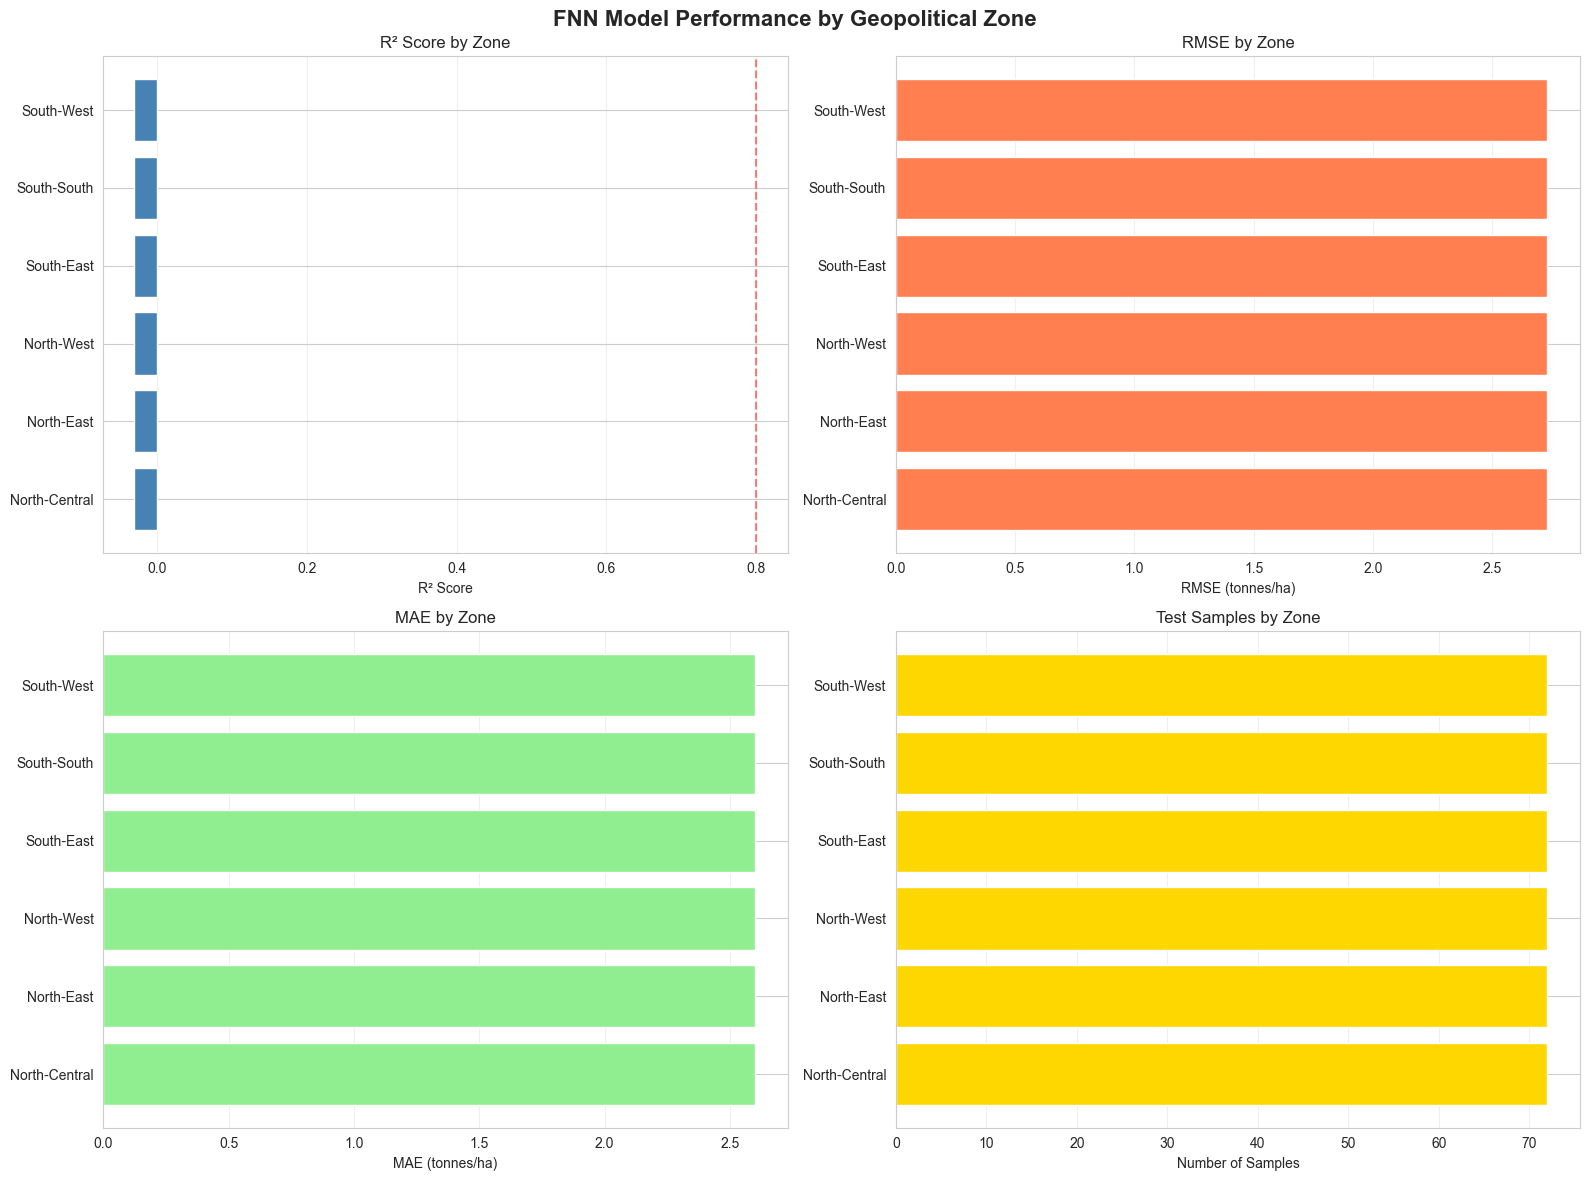

In [7]:
# Visualize zone performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('FNN Model Performance by Geopolitical Zone', fontsize=16, fontweight='bold')

zones = zone_performance.index

# R² by zone
axes[0,0].barh(zones, zone_performance['R2'], color='steelblue')
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('R² Score by Zone')
axes[0,0].axvline(x=0.8, color='red', linestyle='--', alpha=0.5)
axes[0,0].grid(True, alpha=0.3, axis='x')

# RMSE by zone
axes[0,1].barh(zones, zone_performance['RMSE'], color='coral')
axes[0,1].set_xlabel('RMSE (tonnes/ha)')
axes[0,1].set_title('RMSE by Zone')
axes[0,1].grid(True, alpha=0.3, axis='x')

# MAE by zone
axes[1,0].barh(zones, zone_performance['MAE'], color='lightgreen')
axes[1,0].set_xlabel('MAE (tonnes/ha)')
axes[1,0].set_title('MAE by Zone')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Sample size by zone
axes[1,1].barh(zones, zone_performance['N_samples'], color='gold')
axes[1,1].set_xlabel('Number of Samples')
axes[1,1].set_title('Test Samples by Zone')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 1.3 Performance by State

In [8]:
# Calculate metrics by state
state_performance = fnn_results.groupby('State').apply(
    lambda x: pd.Series({
        'Zone': x['Geopolitical_Zone'].iloc[0],
        'N_samples': len(x),
        'RMSE': np.sqrt(mean_squared_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield'])),
        'MAE': mean_absolute_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'R2': r2_score(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'Mean_Actual': x['Yield_tonnes_per_ha'].mean()
    })
).round(4)

state_performance = state_performance.sort_values('R2', ascending=False)

print("\n" + "="*80)
print("TOP 10 STATES BY MODEL PERFORMANCE")
print("="*80)
print(state_performance.head(10).to_string())

print("\n" + "="*80)
print("BOTTOM 10 STATES BY MODEL PERFORMANCE")
print("="*80)
print(state_performance.tail(10).to_string())


TOP 10 STATES BY MODEL PERFORMANCE
                    Zone  N_samples    RMSE     MAE      R2  Mean_Actual
State                                                                   
Abia          South-East         24  2.7321  2.5997 -0.0298       3.3645
Adamawa       North-East         24  2.7321  2.5997 -0.0298       3.3645
Akwa Ibom    South-South         24  2.7321  2.5997 -0.0298       3.3645
Bauchi        North-East         24  2.7321  2.5997 -0.0298       3.3645
Benue      North-Central         24  2.7321  2.5997 -0.0298       3.3645
Borno         North-East         24  2.7321  2.5997 -0.0298       3.3645
Delta        South-South         24  2.7321  2.5997 -0.0298       3.3645
Ebonyi        South-East         24  2.7321  2.5997 -0.0298       3.3645
Enugu         South-East         24  2.7321  2.5997 -0.0298       3.3645
Kaduna        North-West         24  2.7321  2.5997 -0.0298       3.3645

BOTTOM 10 STATES BY MODEL PERFORMANCE
                  Zone  N_samples    RMSE     MAE

---
## 2. Crop-Specific Analysis

In [9]:
# Performance by crop
print("\n" + "="*80)
print("PERFORMANCE BY CROP TYPE")
print("="*80)

crop_performance = fnn_results.groupby('Crop').apply(
    lambda x: pd.Series({
        'N_samples': len(x),
        'RMSE': np.sqrt(mean_squared_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield'])),
        'MAE': mean_absolute_error(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'R2': r2_score(x['Yield_tonnes_per_ha'], x['Predicted_Yield']),
        'Mean_Actual': x['Yield_tonnes_per_ha'].mean(),
        'Mean_Predicted': x['Predicted_Yield'].mean(),
        'MAPE': x['Pct_Error'].mean()
    })
).round(4)

crop_performance = crop_performance.sort_values('R2', ascending=False)
print("\n", crop_performance.to_string())


PERFORMANCE BY CROP TYPE

          N_samples    RMSE     MAE         R2  Mean_Actual  Mean_Predicted      MAPE
Crop                                                                                
Cassava       72.0  2.1759  2.1647   -95.9677       5.9940          3.8293   36.0296
Maize         72.0  1.7634  1.7602  -280.4476       2.0690          3.8293   85.5447
Millet        72.0  2.8516  2.8489  -517.7954       0.9804          3.8293  297.7870
Yams          72.0  4.2420  4.2401 -1109.1083       8.0694          3.8293   52.5340
Rice          72.0  1.9025  1.9020 -1890.5501       1.9273          3.8293   98.7897
Sorghum       72.0  2.6825  2.6824 -9377.6582       1.1469          3.8293  234.0687


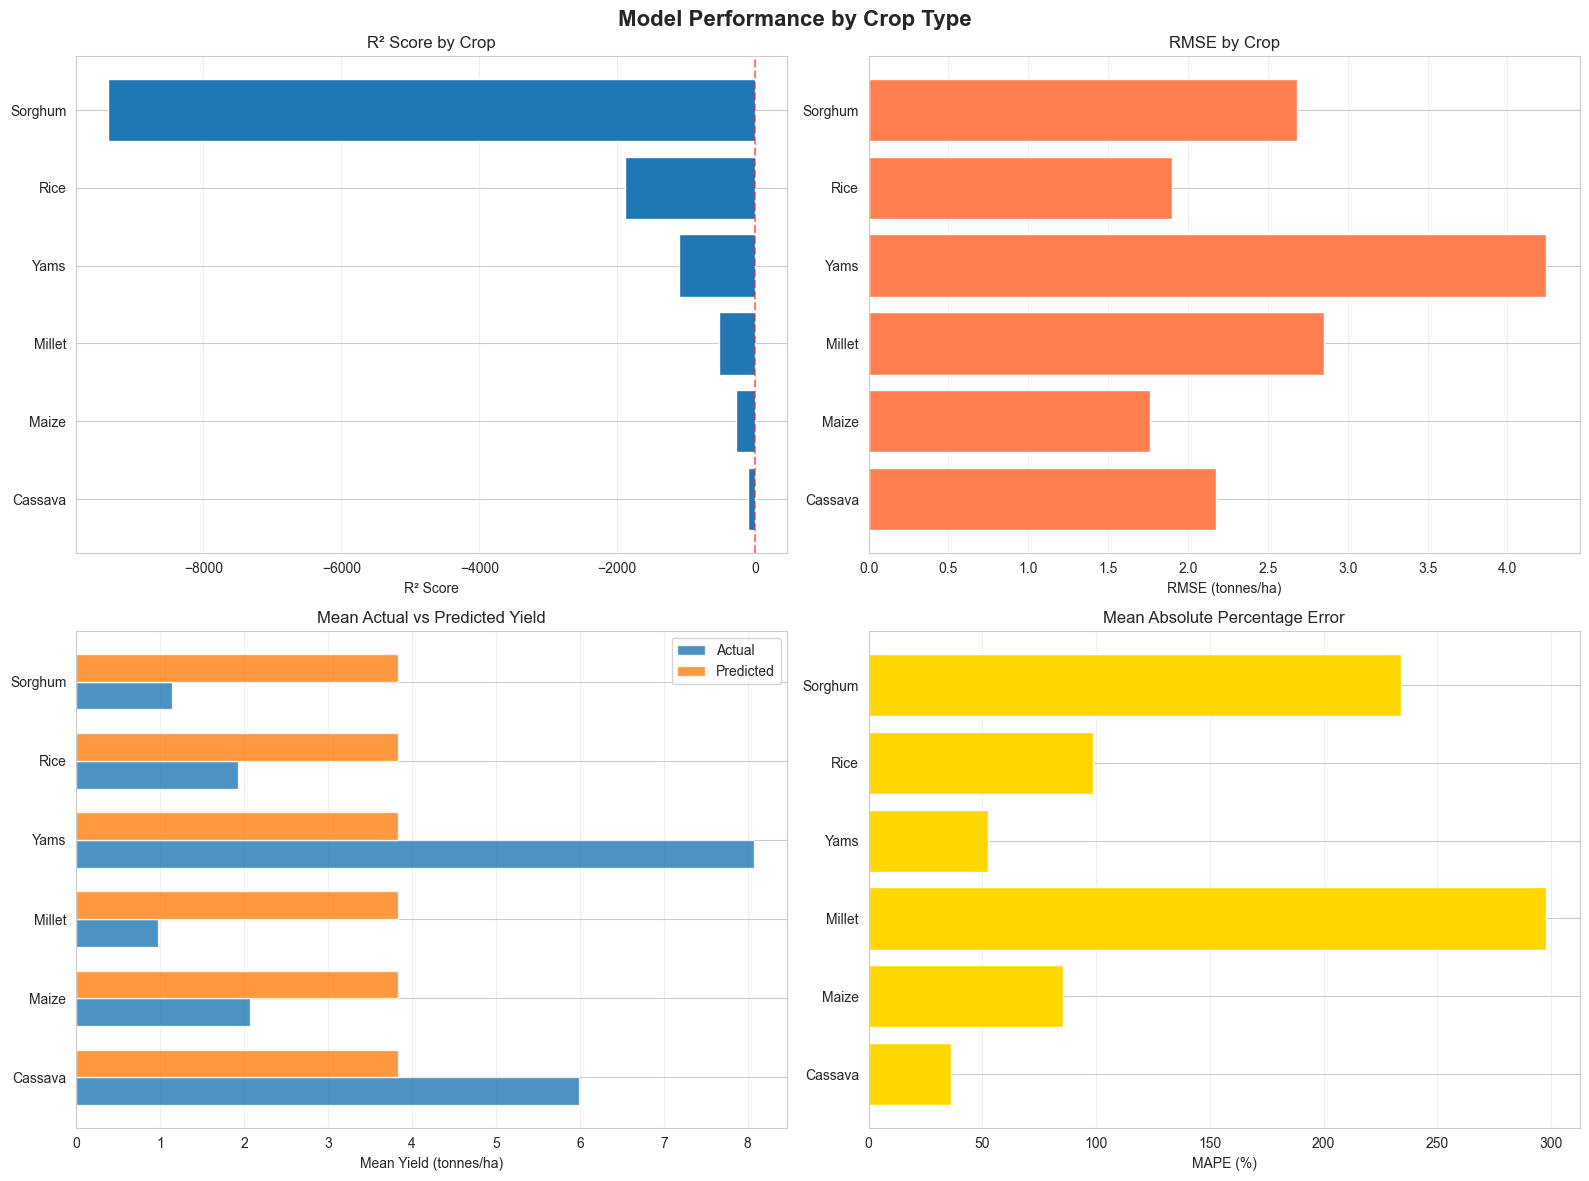

In [10]:
# Visualize crop performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance by Crop Type', fontsize=16, fontweight='bold')

crops = crop_performance.index

# R² by crop
axes[0,0].barh(crops, crop_performance['R2'])
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('R² Score by Crop')
axes[0,0].axvline(x=0.8, color='red', linestyle='--', alpha=0.5)
axes[0,0].grid(True, alpha=0.3, axis='x')

# RMSE by crop
axes[0,1].barh(crops, crop_performance['RMSE'], color='coral')
axes[0,1].set_xlabel('RMSE (tonnes/ha)')
axes[0,1].set_title('RMSE by Crop')
axes[0,1].grid(True, alpha=0.3, axis='x')

# Actual vs Predicted means
x = np.arange(len(crops))
width = 0.35
axes[1,0].barh(x - width/2, crop_performance['Mean_Actual'], width, label='Actual', alpha=0.8)
axes[1,0].barh(x + width/2, crop_performance['Mean_Predicted'], width, label='Predicted', alpha=0.8)
axes[1,0].set_yticks(x)
axes[1,0].set_yticklabels(crops)
axes[1,0].set_xlabel('Mean Yield (tonnes/ha)')
axes[1,0].set_title('Mean Actual vs Predicted Yield')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='x')

# MAPE by crop
axes[1,1].barh(crops, crop_performance['MAPE'], color='gold')
axes[1,1].set_xlabel('MAPE (%)')
axes[1,1].set_title('Mean Absolute Percentage Error')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---
## 3. Error Analysis

In [11]:
# Residual analysis
residuals = fnn_results['Residual'].values

print("\n" + "="*80)
print("RESIDUAL ANALYSIS")
print("="*80)

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std Dev: {residuals.std():.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")
print(f"  Median: {np.median(residuals):.4f}")

# Test for normality
_, p_value = stats.normaltest(residuals)
print(f"\nNormality Test (p-value): {p_value:.4f}")
if p_value > 0.05:
    print("  → Residuals appear normally distributed")
else:
    print("  → Residuals deviate from normal distribution")


RESIDUAL ANALYSIS

Residual Statistics:
  Mean: -0.4648
  Std Dev: 2.6923
  Min: -3.0498
  Max: 4.3742
  Median: -1.8683

Normality Test (p-value): 0.0000
  → Residuals deviate from normal distribution


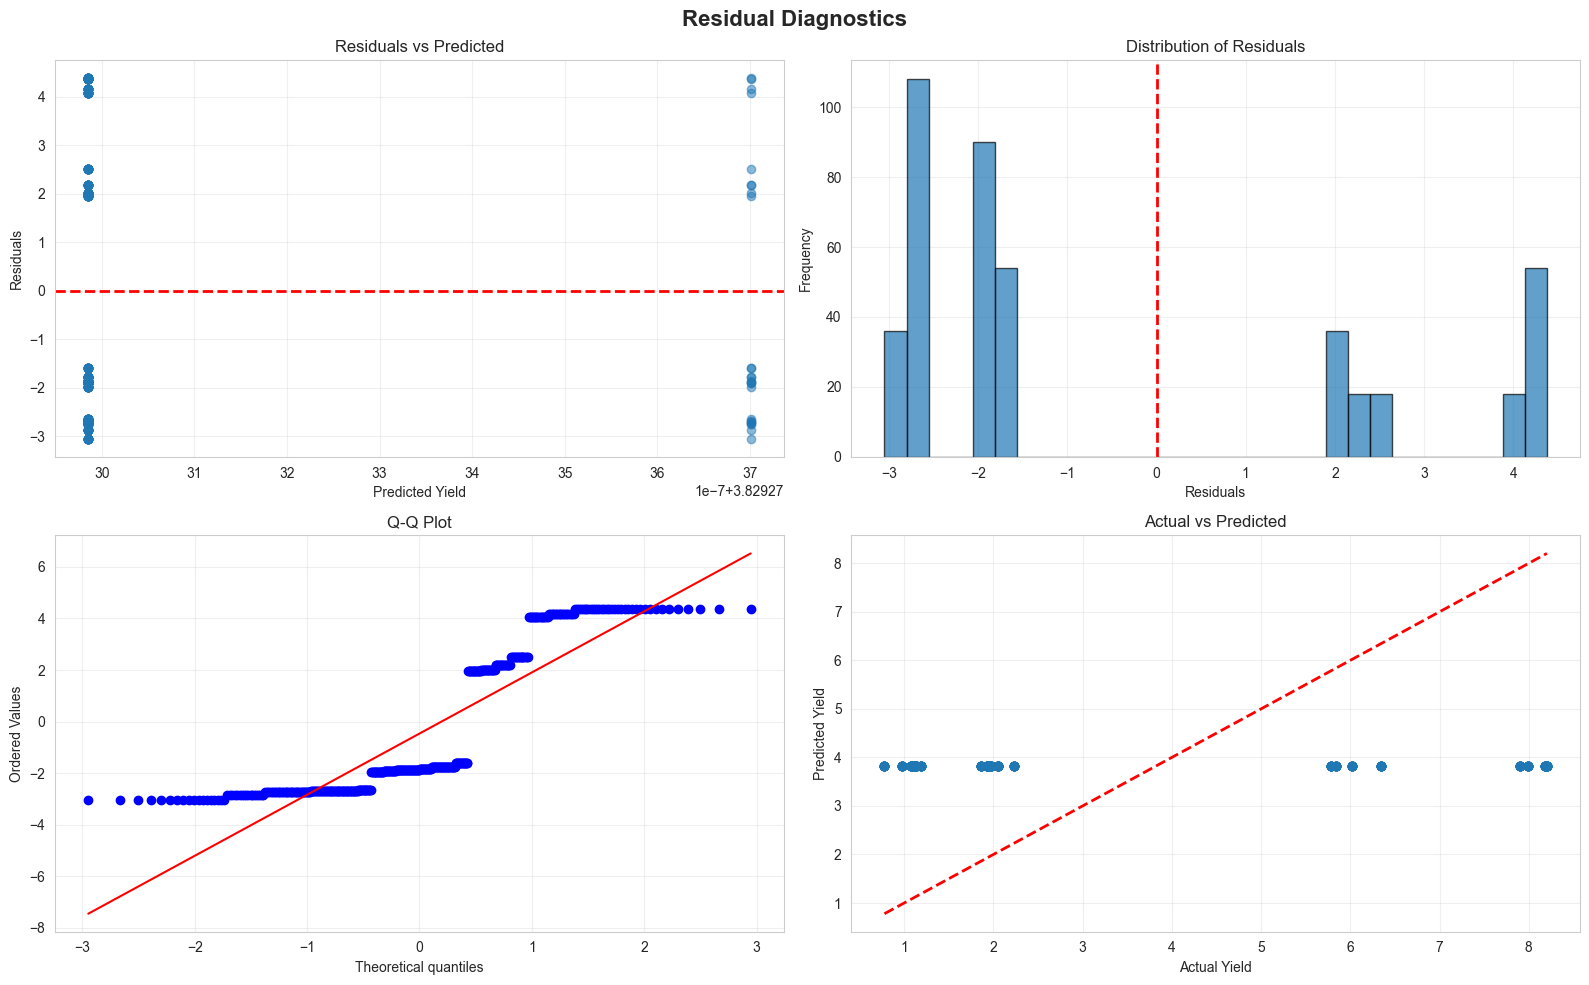

In [12]:
# Residual diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Residual Diagnostics', fontsize=16, fontweight='bold')

# Residuals vs Predicted
axes[0,0].scatter(fnn_results['Predicted_Yield'], residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,0].set_xlabel('Predicted Yield')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Predicted')
axes[0,0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0,1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Residuals')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')
axes[1,0].grid(True, alpha=0.3)

# Actual vs Predicted
axes[1,1].scatter(fnn_results['Yield_tonnes_per_ha'], fnn_results['Predicted_Yield'], alpha=0.5)
min_val = min(fnn_results['Yield_tonnes_per_ha'].min(), fnn_results['Predicted_Yield'].min())
max_val = max(fnn_results['Yield_tonnes_per_ha'].max(), fnn_results['Predicted_Yield'].max())
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1,1].set_xlabel('Actual Yield')
axes[1,1].set_ylabel('Predicted Yield')
axes[1,1].set_title('Actual vs Predicted')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 3.2 Classification Metrics Analysis

Convert continuous yield predictions into categories (Low/Medium/High) to evaluate classification performance using Accuracy, Precision, Recall, and F1-score.

In [13]:
# Import classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define yield categories based on terciles (Low, Medium, High)
print("\n" + "="*80)
print("CLASSIFICATION METRICS - YIELD CATEGORIES")
print("="*80)

# Calculate terciles for actual yields
terciles = fnn_results['Yield_tonnes_per_ha'].quantile([0.33, 0.67])
print(f"\nYield Category Thresholds:")
print(f"  Low: < {terciles[0.33]:.2f} tonnes/ha")
print(f"  Medium: {terciles[0.33]:.2f} - {terciles[0.67]:.2f} tonnes/ha")
print(f"  High: > {terciles[0.67]:.2f} tonnes/ha")

# Categorize actual and predicted yields
def categorize_yield(yield_value, low_threshold, high_threshold):
    if yield_value < low_threshold:
        return 'Low'
    elif yield_value < high_threshold:
        return 'Medium'
    else:
        return 'High'

fnn_results['Actual_Category'] = fnn_results['Yield_tonnes_per_ha'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)
fnn_results['Predicted_Category'] = fnn_results['Predicted_Yield'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)

# Calculate classification metrics
y_true = fnn_results['Actual_Category']
y_pred = fnn_results['Predicted_Category']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\n📊 Overall Classification Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Per-class metrics
print(f"\n📋 Per-Class Metrics:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))


CLASSIFICATION METRICS - YIELD CATEGORIES

Yield Category Thresholds:
  Low: < 1.19 tonnes/ha
  Medium: 1.19 - 5.78 tonnes/ha
  High: > 5.78 tonnes/ha

📊 Overall Classification Metrics:
  Accuracy:  0.3750 (37.50%)
  Precision: 0.1406
  Recall:    0.3750
  F1-Score:  0.2045

📋 Per-Class Metrics:
              precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000       144
         Low     0.0000    0.0000    0.0000       126
      Medium     0.3750    1.0000    0.5455       162

    accuracy                         0.3750       432
   macro avg     0.1250    0.3333    0.1818       432
weighted avg     0.1406    0.3750    0.2045       432



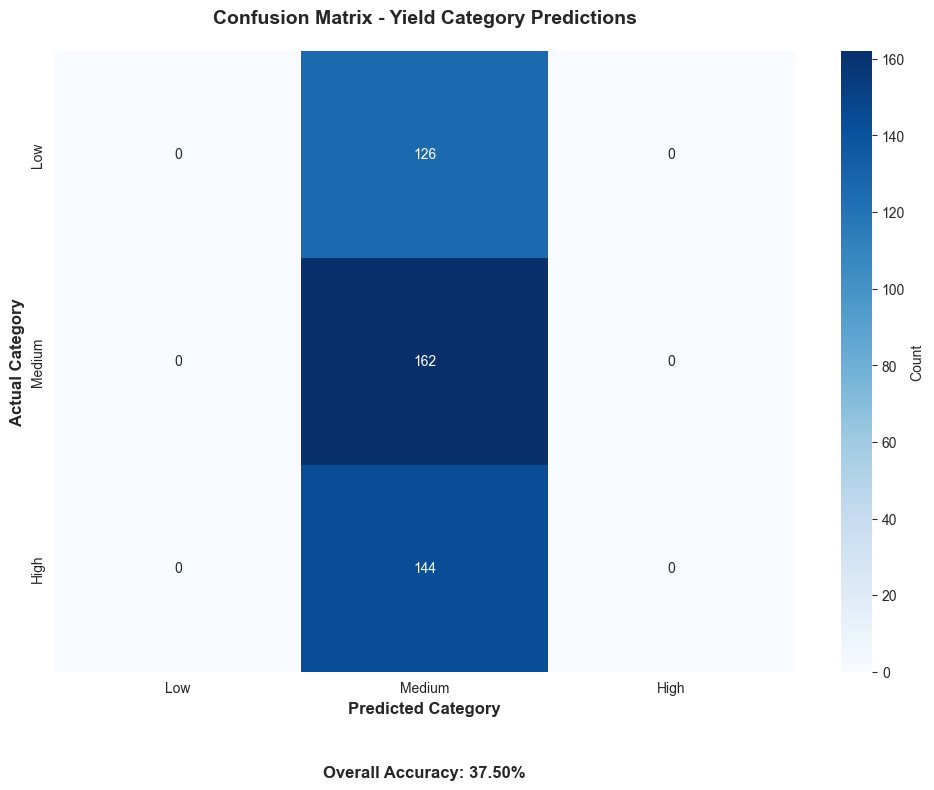


📊 Confusion Matrix Interpretation:
  • Diagonal values = correct predictions
  • Off-diagonal values = misclassifications
  • Total samples: 432


In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['Low', 'Medium', 'High'])

# Visualize confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual Category', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Yield Category Predictions', fontsize=14, fontweight='bold', pad=20)

# Add accuracy text
plt.text(0.5, -0.15, f'Overall Accuracy: {accuracy:.2%}', 
         ha='center', va='top', transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Interpretation:")
print("  • Diagonal values = correct predictions")
print("  • Off-diagonal values = misclassifications")
print(f"  • Total samples: {cm.sum()}")


CLASSIFICATION METRICS BY GEOPOLITICAL ZONE

                    N_samples  Accuracy  Precision  Recall  F1_Score
Geopolitical_Zone                                                  
North-Central           72.0     0.375     0.1406   0.375    0.2045
North-East              72.0     0.375     0.1406   0.375    0.2045
North-West              72.0     0.375     0.1406   0.375    0.2045
South-East              72.0     0.375     0.1406   0.375    0.2045
South-South             72.0     0.375     0.1406   0.375    0.2045
South-West              72.0     0.375     0.1406   0.375    0.2045


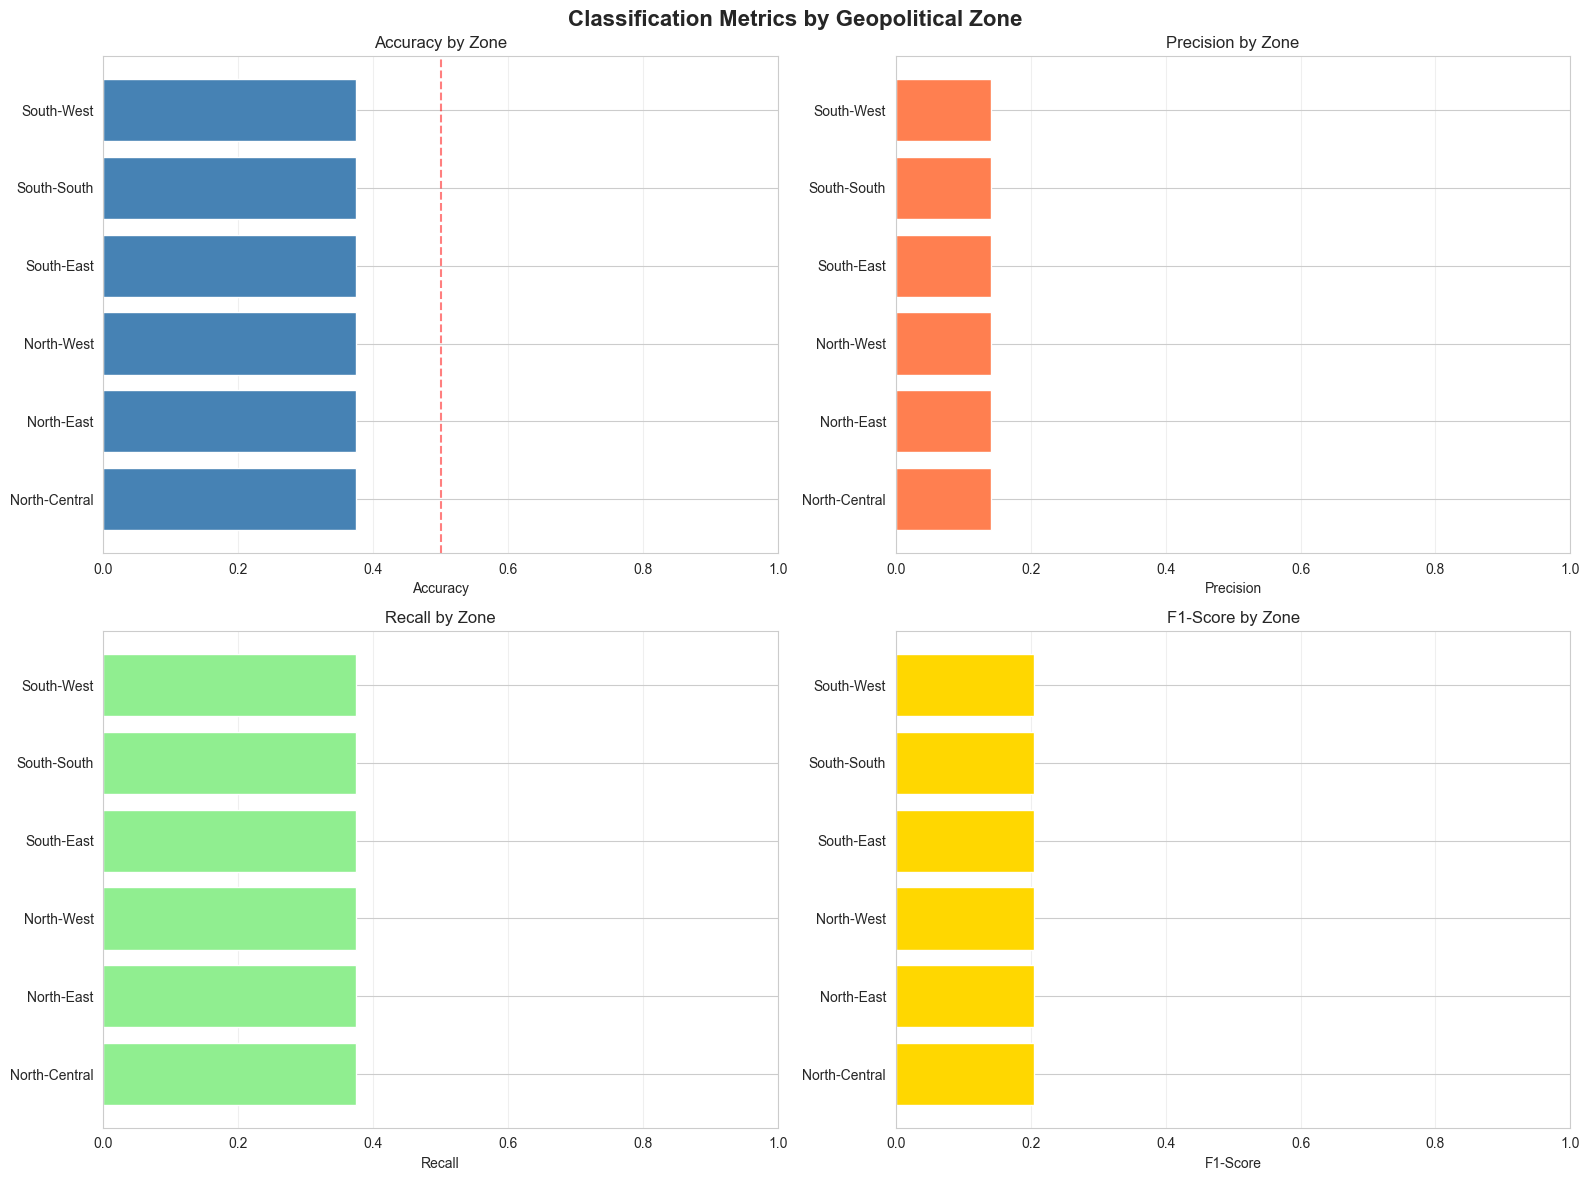

In [15]:
# Classification metrics by Zone
print("\n" + "="*80)
print("CLASSIFICATION METRICS BY GEOPOLITICAL ZONE")
print("="*80)

zone_class_metrics = fnn_results.groupby('Geopolitical_Zone').apply(
    lambda x: pd.Series({
        'N_samples': len(x),
        'Accuracy': accuracy_score(x['Actual_Category'], x['Predicted_Category']),
        'Precision': precision_score(x['Actual_Category'], x['Predicted_Category'], 
                                     average='weighted', zero_division=0),
        'Recall': recall_score(x['Actual_Category'], x['Predicted_Category'], 
                              average='weighted', zero_division=0),
        'F1_Score': f1_score(x['Actual_Category'], x['Predicted_Category'], 
                            average='weighted', zero_division=0)
    })
).round(4)

zone_class_metrics = zone_class_metrics.sort_values('Accuracy', ascending=False)
print("\n", zone_class_metrics.to_string())

# Visualize classification metrics by zone
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Classification Metrics by Geopolitical Zone', fontsize=16, fontweight='bold')

zones = zone_class_metrics.index

# Accuracy by zone
axes[0,0].barh(zones, zone_class_metrics['Accuracy'], color='steelblue')
axes[0,0].set_xlabel('Accuracy')
axes[0,0].set_title('Accuracy by Zone')
axes[0,0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[0,0].grid(True, alpha=0.3, axis='x')
axes[0,0].set_xlim(0, 1)

# Precision by zone
axes[0,1].barh(zones, zone_class_metrics['Precision'], color='coral')
axes[0,1].set_xlabel('Precision')
axes[0,1].set_title('Precision by Zone')
axes[0,1].grid(True, alpha=0.3, axis='x')
axes[0,1].set_xlim(0, 1)

# Recall by zone
axes[1,0].barh(zones, zone_class_metrics['Recall'], color='lightgreen')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_title('Recall by Zone')
axes[1,0].grid(True, alpha=0.3, axis='x')
axes[1,0].set_xlim(0, 1)

# F1-Score by zone
axes[1,1].barh(zones, zone_class_metrics['F1_Score'], color='gold')
axes[1,1].set_xlabel('F1-Score')
axes[1,1].set_title('F1-Score by Zone')
axes[1,1].grid(True, alpha=0.3, axis='x')
axes[1,1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


CLASSIFICATION METRICS BY CROP TYPE

          N_samples  Accuracy  Precision  Recall  F1_Score
Crop                                                     
Maize         72.0      1.00     1.0000    1.00       1.0
Rice          72.0      1.00     1.0000    1.00       1.0
Sorghum       72.0      0.25     0.0625    0.25       0.1
Cassava       72.0      0.00     0.0000    0.00       0.0
Millet        72.0      0.00     0.0000    0.00       0.0
Yams          72.0      0.00     0.0000    0.00       0.0


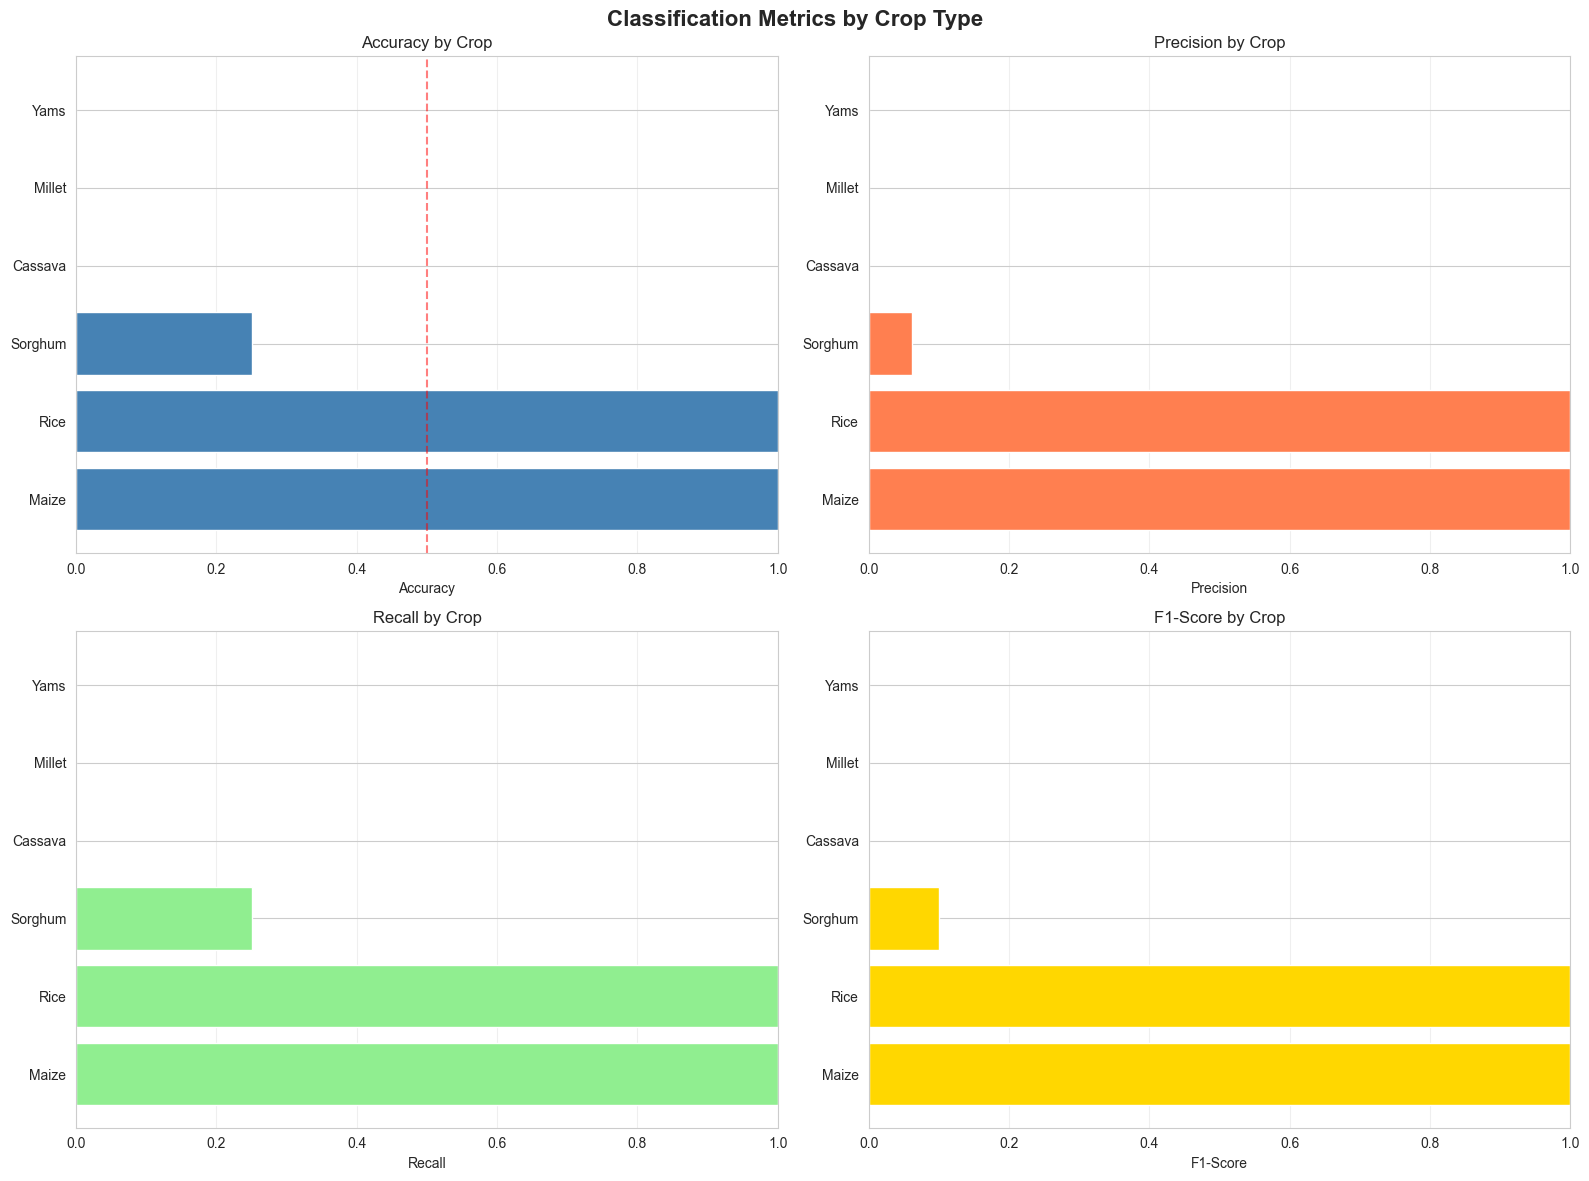

In [16]:
# Classification metrics by Crop
print("\n" + "="*80)
print("CLASSIFICATION METRICS BY CROP TYPE")
print("="*80)

crop_class_metrics = fnn_results.groupby('Crop').apply(
    lambda x: pd.Series({
        'N_samples': len(x),
        'Accuracy': accuracy_score(x['Actual_Category'], x['Predicted_Category']),
        'Precision': precision_score(x['Actual_Category'], x['Predicted_Category'], 
                                     average='weighted', zero_division=0),
        'Recall': recall_score(x['Actual_Category'], x['Predicted_Category'], 
                              average='weighted', zero_division=0),
        'F1_Score': f1_score(x['Actual_Category'], x['Predicted_Category'], 
                            average='weighted', zero_division=0)
    })
).round(4)

crop_class_metrics = crop_class_metrics.sort_values('Accuracy', ascending=False)
print("\n", crop_class_metrics.to_string())

# Visualize classification metrics by crop
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Classification Metrics by Crop Type', fontsize=16, fontweight='bold')

crops = crop_class_metrics.index

# Accuracy by crop
axes[0,0].barh(crops, crop_class_metrics['Accuracy'], color='steelblue')
axes[0,0].set_xlabel('Accuracy')
axes[0,0].set_title('Accuracy by Crop')
axes[0,0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
axes[0,0].grid(True, alpha=0.3, axis='x')
axes[0,0].set_xlim(0, 1)

# Precision by crop
axes[0,1].barh(crops, crop_class_metrics['Precision'], color='coral')
axes[0,1].set_xlabel('Precision')
axes[0,1].set_title('Precision by Crop')
axes[0,1].grid(True, alpha=0.3, axis='x')
axes[0,1].set_xlim(0, 1)

# Recall by crop
axes[1,0].barh(crops, crop_class_metrics['Recall'], color='lightgreen')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_title('Recall by Crop')
axes[1,0].grid(True, alpha=0.3, axis='x')
axes[1,0].set_xlim(0, 1)

# F1-Score by crop
axes[1,1].barh(crops, crop_class_metrics['F1_Score'], color='gold')
axes[1,1].set_xlabel('F1-Score')
axes[1,1].set_title('F1-Score by Crop')
axes[1,1].grid(True, alpha=0.3, axis='x')
axes[1,1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

---
## 3.3 LSTM Model Validation

Validate the LSTM model which processes sequential temporal data to capture time-series patterns.

In [17]:
# Prepare LSTM predictions
print("\n" + "="*80)
print("LSTM MODEL - GENERATING PREDICTIONS")
print("="*80)

# LSTM requires sequence format (samples, timesteps, features)
# Define temporal features for LSTM (same as training - 12 climate + 1 encoding)
lstm_temp_cols = [
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C',
    'Rainfall_mm', 'Rainy_Days', 'Rainfall_Intensity',
    'Avg_Humidity_Percent',
    'CO2_ppm',
    'Heat_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    'Is_Growing_Season'
]

# Validate encoders for LSTM test
print("  Validating categorical encoders...")
for col, encoder, name in [('Crop', le_crop, 'Crop')]:
    unique_vals = lstm_test[col].unique()
    unknown_vals = [v for v in unique_vals if v not in encoder.classes_]
    if unknown_vals:
        print(f"    ⚠ Warning: Unknown {name} values: {unknown_vals}")
        lstm_test = lstm_test[~lstm_test[col].isin(unknown_vals)]

# Add crop encoding
lstm_test['Crop_encoded'] = le_crop.transform(lstm_test['Crop'])
lstm_feature_cols = lstm_temp_cols + ['Crop_encoded']

# Prepare LSTM input (reshape to sequence format)
X_lstm_test = lstm_test[lstm_feature_cols].values
X_lstm_test_scaled = lstm_scaler.transform(X_lstm_test)
# Reshape for LSTM: (samples, timesteps=1, features)
X_lstm_test_scaled = X_lstm_test_scaled.reshape((X_lstm_test_scaled.shape[0], 1, X_lstm_test_scaled.shape[1]))

# Generate predictions
lstm_predictions = lstm_model.predict(X_lstm_test_scaled, verbose=0).flatten()

# Create results dataframe
lstm_results = lstm_test[['Year', 'Geopolitical_Zone', 'State', 'Crop', 'Yield_tonnes_per_ha']].copy()
lstm_results['Predicted_Yield'] = lstm_predictions
lstm_results['Residual'] = lstm_results['Yield_tonnes_per_ha'] - lstm_results['Predicted_Yield']
lstm_results['Abs_Error'] = np.abs(lstm_results['Residual'])
lstm_results['Pct_Error'] = np.where(
    lstm_results['Yield_tonnes_per_ha'] > 0.01,
    (lstm_results['Abs_Error'] / lstm_results['Yield_tonnes_per_ha']) * 100,
    np.nan
)

# Calculate overall metrics
lstm_rmse = np.sqrt(mean_squared_error(lstm_results['Yield_tonnes_per_ha'], lstm_results['Predicted_Yield']))
lstm_mae = mean_absolute_error(lstm_results['Yield_tonnes_per_ha'], lstm_results['Predicted_Yield'])
lstm_r2 = r2_score(lstm_results['Yield_tonnes_per_ha'], lstm_results['Predicted_Yield'])

print(f"\n  ✓ LSTM predictions generated: {len(lstm_results)}")
print(f"\n📊 LSTM Overall Performance:")
print(f"  RMSE: {lstm_rmse:.4f} tonnes/ha")
print(f"  MAE: {lstm_mae:.4f} tonnes/ha")
print(f"  R²: {lstm_r2:.4f}")


LSTM MODEL - GENERATING PREDICTIONS
  Validating categorical encoders...

  ✓ LSTM predictions generated: 5184

📊 LSTM Overall Performance:
  RMSE: 3.4196 tonnes/ha
  MAE: 2.2565 tonnes/ha
  R²: -0.6133


In [18]:
# LSTM Classification Metrics
lstm_results['Actual_Category'] = lstm_results['Yield_tonnes_per_ha'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)
lstm_results['Predicted_Category'] = lstm_results['Predicted_Yield'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)

lstm_accuracy = accuracy_score(lstm_results['Actual_Category'], lstm_results['Predicted_Category'])
lstm_precision = precision_score(lstm_results['Actual_Category'], lstm_results['Predicted_Category'], 
                                 average='weighted', zero_division=0)
lstm_recall = recall_score(lstm_results['Actual_Category'], lstm_results['Predicted_Category'], 
                            average='weighted', zero_division=0)
lstm_f1 = f1_score(lstm_results['Actual_Category'], lstm_results['Predicted_Category'], 
                   average='weighted', zero_division=0)

print("\n📊 LSTM Classification Metrics:")
print(f"  Accuracy:  {lstm_accuracy:.4f} ({lstm_accuracy*100:.2f}%)")
print(f"  Precision: {lstm_precision:.4f}")
print(f"  Recall:    {lstm_recall:.4f}")
print(f"  F1-Score:  {lstm_f1:.4f}")


📊 LSTM Classification Metrics:
  Accuracy:  0.3405 (34.05%)
  Precision: 0.2255
  Recall:    0.3405
  F1-Score:  0.2710


---
## 3.4 Hybrid Model Validation

Validate the Hybrid model which combines LSTM temporal processing with FNN statistical analysis.

In [19]:
# Prepare Hybrid model predictions
print("\n" + "="*80)
print("HYBRID MODEL - GENERATING PREDICTIONS")
print("="*80)

# Hybrid model uses sequences (12 months) + static features
# Define features
hybrid_temp_cols = [
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C',
    'Rainfall_mm', 'Rainy_Days', 'Rainfall_Intensity',
    'Avg_Humidity_Percent',
    'CO2_ppm',
    'Heat_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    'Is_Growing_Season'
]

hybrid_stat_cols = [
    'Soil_pH', 'Organic_Matter_Percent', 'Nitrogen_ppm', 
    'Phosphorus_ppm', 'Potassium_ppm', 'Cation_Exchange_Capacity',
    'Bulk_Density', 'Water_Holding_Capacity_Percent'
]

# Validate encoders
print("  Validating categorical encoders...")
for col, encoder, name in [('Crop', le_crop, 'Crop'),
                            ('Geopolitical_Zone', le_zone, 'Zone')]:
    unique_vals = hybrid_test[col].unique()
    unknown_vals = [v for v in unique_vals if v not in encoder.classes_]
    if unknown_vals:
        print(f"    ⚠ Warning: Unknown {name} values: {unknown_vals}")
        hybrid_test = hybrid_test[~hybrid_test[col].isin(unknown_vals)]

# Add encodings
hybrid_test['Crop_encoded'] = le_crop.transform(hybrid_test['Crop'])
hybrid_test['Zone_encoded'] = le_zone.transform(hybrid_test['Geopolitical_Zone'])
hybrid_stat_cols_with_enc = hybrid_stat_cols + ['Crop_encoded', 'Zone_encoded']

# Create sequences (same as Phase 3 training)
print("  Creating 12-month sequences...")
sequence_length = 12

# Function to create sequences
def create_hybrid_sequences(data, temp_cols, stat_cols, target_col='Yield_tonnes_per_ha', seq_len=12):
    X_temporal, X_static, y_targets, metadata = [], [], [], []
    
    grouped = data.groupby(['Year', 'State', 'Crop'])
    for name, group in grouped:
        group = group.sort_values('Month')
        if len(group) >= seq_len:
            temporal = group[temp_cols].values[:seq_len]
            static = group[stat_cols].iloc[0].values
            target = group[target_col].iloc[0]
            
            X_temporal.append(temporal)
            X_static.append(static)
            y_targets.append(target)
            metadata.append({'Year': name[0], 'State': name[1], 'Crop': name[2]})
    
    return (np.array(X_temporal), np.array(X_static), np.array(y_targets), metadata)

# Create sequences
X_hybrid_temp, X_hybrid_stat, y_hybrid, hybrid_metadata = create_hybrid_sequences(
    hybrid_test, hybrid_temp_cols, hybrid_stat_cols_with_enc, 'Yield_tonnes_per_ha', sequence_length
)

print(f"    Temporal sequences: {X_hybrid_temp.shape}")
print(f"    Static features: {X_hybrid_stat.shape}")

# Scale features
n_samples, seq_len, n_temp_feat = X_hybrid_temp.shape
X_hybrid_temp_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp.reshape(-1, n_temp_feat)
).reshape(n_samples, seq_len, n_temp_feat)

X_hybrid_stat_scaled = hybrid_stat_scaler.transform(X_hybrid_stat)

# Generate predictions with dual inputs
hybrid_predictions = hybrid_model.predict([X_hybrid_temp_scaled, X_hybrid_stat_scaled], verbose=0).flatten()

# Create results dataframe from metadata
hybrid_results = pd.DataFrame(hybrid_metadata)
hybrid_results['Geopolitical_Zone'] = hybrid_results['State'].map(
    lambda s: hybrid_test[hybrid_test['State'] == s]['Geopolitical_Zone'].iloc[0] if len(hybrid_test[hybrid_test['State'] == s]) > 0 else 'Unknown'
)
hybrid_results['Yield_tonnes_per_ha'] = y_hybrid
hybrid_results['Predicted_Yield'] = hybrid_predictions
hybrid_results['Residual'] = hybrid_results['Yield_tonnes_per_ha'] - hybrid_results['Predicted_Yield']
hybrid_results['Abs_Error'] = np.abs(hybrid_results['Residual'])
hybrid_results['Pct_Error'] = np.where(
    hybrid_results['Yield_tonnes_per_ha'] > 0.01,
    (hybrid_results['Abs_Error'] / hybrid_results['Yield_tonnes_per_ha']) * 100,
    np.nan
)

# Calculate overall metrics
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_results['Yield_tonnes_per_ha'], hybrid_results['Predicted_Yield']))
hybrid_mae = mean_absolute_error(hybrid_results['Yield_tonnes_per_ha'], hybrid_results['Predicted_Yield'])
hybrid_r2 = r2_score(hybrid_results['Yield_tonnes_per_ha'], hybrid_results['Predicted_Yield'])

print(f"\n  ✓ Hybrid predictions generated: {len(hybrid_results)}")
print(f"\n📊 Hybrid Overall Performance:")
print(f"  RMSE: {hybrid_rmse:.4f} tonnes/ha")
print(f"  MAE: {hybrid_mae:.4f} tonnes/ha")
print(f"  R²: {hybrid_r2:.4f}")


HYBRID MODEL - GENERATING PREDICTIONS
  Validating categorical encoders...
  Creating 12-month sequences...
    Temporal sequences: (432, 12, 12)
    Static features: (432, 10)

  ✓ Hybrid predictions generated: 432

📊 Hybrid Overall Performance:
  RMSE: 1.1339 tonnes/ha
  MAE: 0.8314 tonnes/ha
  R²: 0.8226


In [20]:
# Hybrid Classification Metrics
hybrid_results['Actual_Category'] = hybrid_results['Yield_tonnes_per_ha'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)
hybrid_results['Predicted_Category'] = hybrid_results['Predicted_Yield'].apply(
    lambda x: categorize_yield(x, terciles[0.33], terciles[0.67])
)

hybrid_accuracy = accuracy_score(hybrid_results['Actual_Category'], hybrid_results['Predicted_Category'])
hybrid_precision = precision_score(hybrid_results['Actual_Category'], hybrid_results['Predicted_Category'], 
                                   average='weighted', zero_division=0)
hybrid_recall = recall_score(hybrid_results['Actual_Category'], hybrid_results['Predicted_Category'], 
                              average='weighted', zero_division=0)
hybrid_f1 = f1_score(hybrid_results['Actual_Category'], hybrid_results['Predicted_Category'], 
                     average='weighted', zero_division=0)

print("\n📊 Hybrid Classification Metrics:")
print(f"  Accuracy:  {hybrid_accuracy:.4f} ({hybrid_accuracy*100:.2f}%)")
print(f"  Precision: {hybrid_precision:.4f}")
print(f"  Recall:    {hybrid_recall:.4f}")
print(f"  F1-Score:  {hybrid_f1:.4f}")


📊 Hybrid Classification Metrics:
  Accuracy:  0.7269 (72.69%)
  Precision: 0.7247
  Recall:    0.7269
  F1-Score:  0.6938


---
## 3.5 Model Comparison

Compare all three models side-by-side to identify the best performer.

In [21]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL COMPARISON - ALL THREE MODELS")
print("="*80)

# Calculate FNN overall metrics
overall_rmse = np.sqrt(mean_squared_error(fnn_results['Yield_tonnes_per_ha'], fnn_results['Predicted_Yield']))
overall_mae = mean_absolute_error(fnn_results['Yield_tonnes_per_ha'], fnn_results['Predicted_Yield'])
overall_r2 = r2_score(fnn_results['Yield_tonnes_per_ha'], fnn_results['Predicted_Yield'])

comparison_df = pd.DataFrame({
    'Model': ['FNN', 'LSTM', 'Hybrid'],
    'Samples': [len(fnn_results), len(lstm_results), len(hybrid_results)],
    'RMSE': [overall_rmse, lstm_rmse, hybrid_rmse],
    'MAE': [overall_mae, lstm_mae, hybrid_mae],
    'R²': [overall_r2, lstm_r2, hybrid_r2],
    'Accuracy': [accuracy, lstm_accuracy, hybrid_accuracy],
    'Precision': [precision, lstm_precision, hybrid_precision],
    'Recall': [recall, lstm_recall, hybrid_recall],
    'F1-Score': [f1, lstm_f1, hybrid_f1]
})

print("\n📊 Regression Metrics Comparison:")
print(comparison_df[['Model', 'RMSE', 'MAE', 'R²']].to_string(index=False))

print("\n📊 Classification Metrics Comparison:")
print(comparison_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# Identify best model for each metric
print("\n🏆 Best Model by Metric:")
print(f"  Lowest RMSE: {comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']} ({comparison_df['RMSE'].min():.4f})")
print(f"  Lowest MAE: {comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']} ({comparison_df['MAE'].min():.4f})")
print(f"  Highest R²: {comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']} ({comparison_df['R²'].max():.4f})")
print(f"  Highest Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")
print(f"  Highest F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']} ({comparison_df['F1-Score'].max():.4f})")


MODEL COMPARISON - ALL THREE MODELS

📊 Regression Metrics Comparison:
 Model   RMSE    MAE      R²
   FNN 2.7321 2.5997 -0.0298
  LSTM 3.4196 2.2565 -0.6133
Hybrid 1.1339 0.8314  0.8226

📊 Classification Metrics Comparison:
 Model  Accuracy  Precision  Recall  F1-Score
   FNN    0.3750     0.1406  0.3750    0.2045
  LSTM    0.3405     0.2255  0.3405    0.2710
Hybrid    0.7269     0.7247  0.7269    0.6938

🏆 Best Model by Metric:
  Lowest RMSE: Hybrid (1.1339)
  Lowest MAE: Hybrid (0.8314)
  Highest R²: Hybrid (0.8226)
  Highest Accuracy: Hybrid (0.7269)
  Highest F1-Score: Hybrid (0.6938)


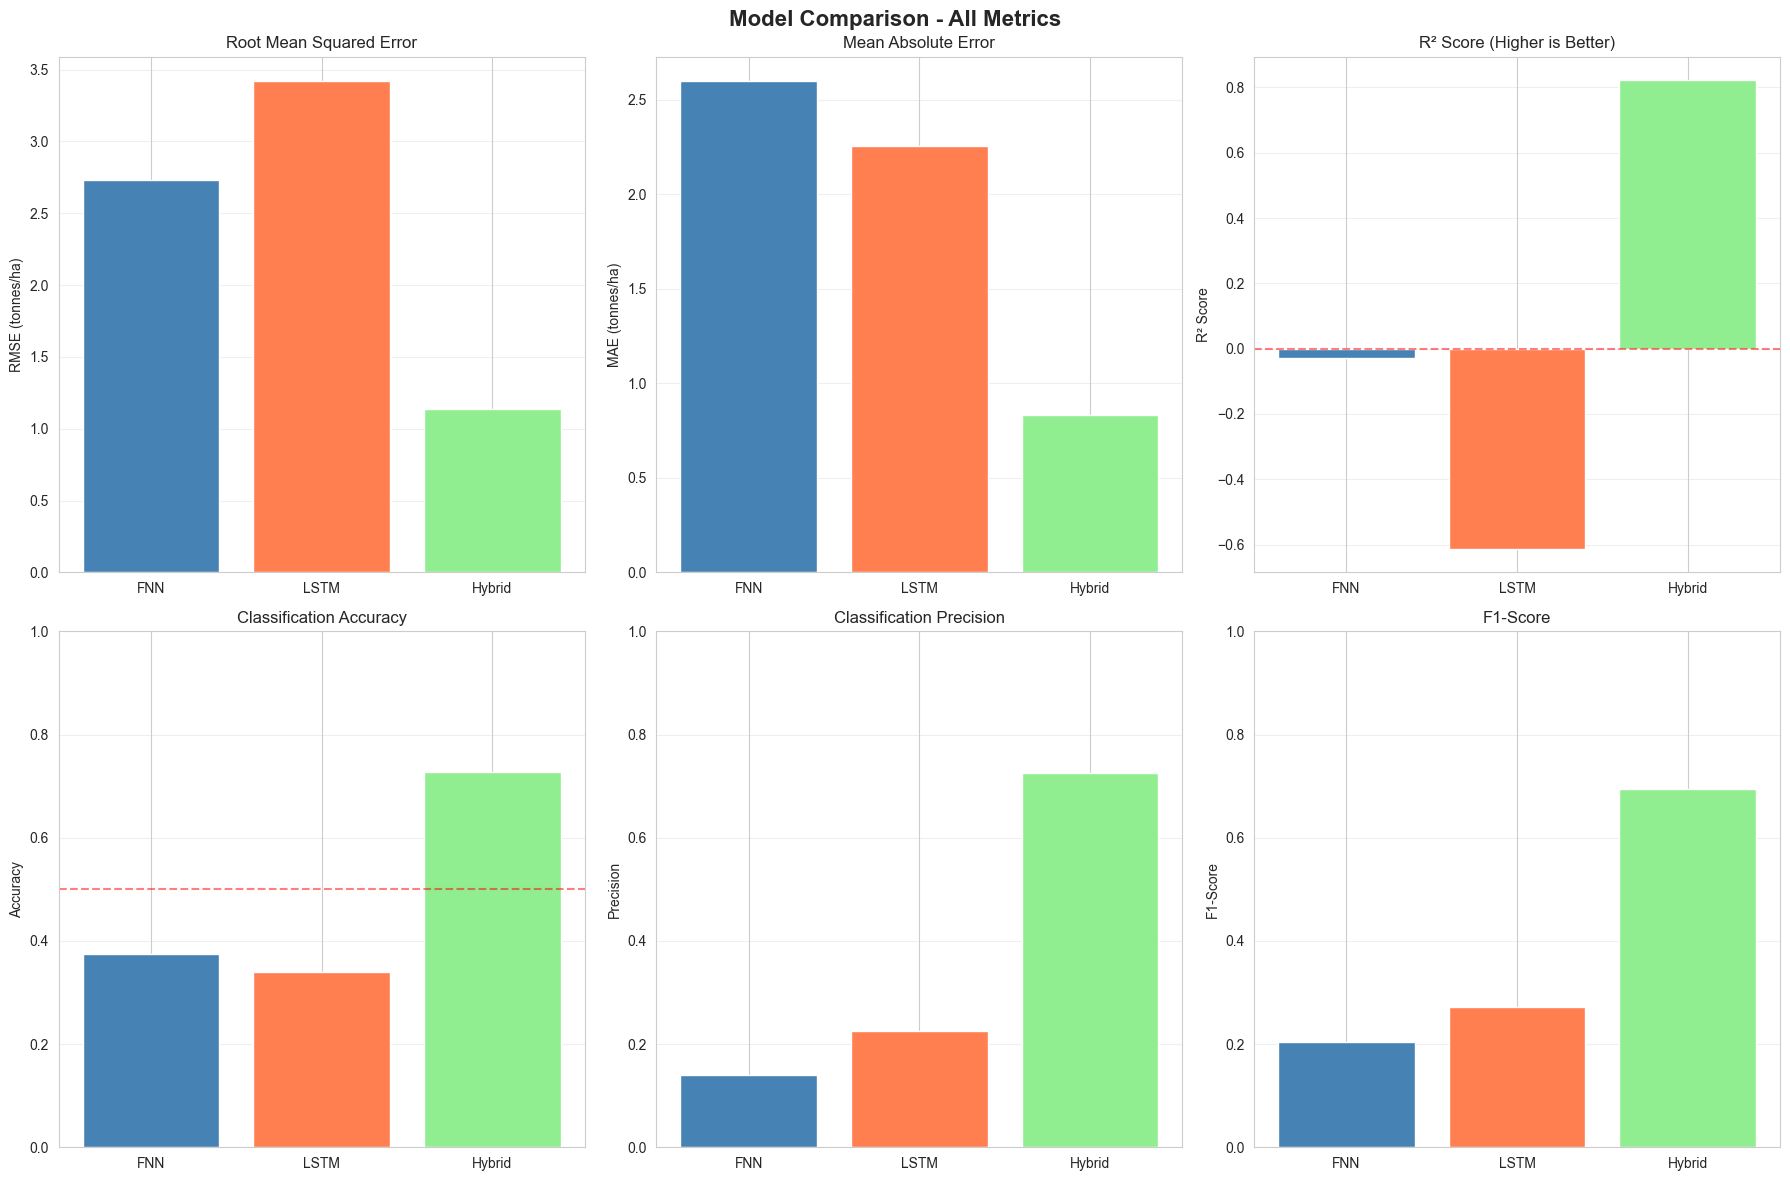

In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Comparison - All Metrics', fontsize=16, fontweight='bold')

models = comparison_df['Model']
colors = ['steelblue', 'coral', 'lightgreen']

# RMSE comparison
axes[0,0].bar(models, comparison_df['RMSE'], color=colors)
axes[0,0].set_ylabel('RMSE (tonnes/ha)')
axes[0,0].set_title('Root Mean Squared Error')
axes[0,0].grid(True, alpha=0.3, axis='y')

# MAE comparison
axes[0,1].bar(models, comparison_df['MAE'], color=colors)
axes[0,1].set_ylabel('MAE (tonnes/ha)')
axes[0,1].set_title('Mean Absolute Error')
axes[0,1].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[0,2].bar(models, comparison_df['R²'], color=colors)
axes[0,2].set_ylabel('R² Score')
axes[0,2].set_title('R² Score (Higher is Better)')
axes[0,2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0,2].grid(True, alpha=0.3, axis='y')

# Accuracy comparison
axes[1,0].bar(models, comparison_df['Accuracy'], color=colors)
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Classification Accuracy')
axes[1,0].set_ylim(0, 1)
axes[1,0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% baseline')
axes[1,0].grid(True, alpha=0.3, axis='y')

# Precision comparison
axes[1,1].bar(models, comparison_df['Precision'], color=colors)
axes[1,1].set_ylabel('Precision')
axes[1,1].set_title('Classification Precision')
axes[1,1].set_ylim(0, 1)
axes[1,1].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
axes[1,2].bar(models, comparison_df['F1-Score'], color=colors)
axes[1,2].set_ylabel('F1-Score')
axes[1,2].set_title('F1-Score')
axes[1,2].set_ylim(0, 1)
axes[1,2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## 4. Feature Importance Analysis (Permutation Importance)

**Analysis Focus:** Using Permutation Importance on the best-performing Hybrid model to understand which static features (soil properties and location/crop encodings) contribute most to yield predictions.

### 4.1 Prepare Sample for SHAP Analysis

In [23]:
# Sample data for SHAP analysis (use a representative subset for computational efficiency)
print("Preparing data for SHAP analysis...")

# Use stratified sampling to get representative subset (500 samples)
np.random.seed(42)
sample_indices = np.random.choice(len(X_fnn_test_scaled), size=min(500, len(X_fnn_test_scaled)), replace=False)
X_sample = X_fnn_test_scaled[sample_indices]

# Feature names for better interpretability
feature_names = [
    'Avg Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Temp Range (°C)',
    'Rainfall (mm)', 'Rainy Days', 'Max Daily Rainfall (mm)', 'Rainfall Intensity',
    'Avg Humidity (%)', 'Min Humidity (%)', 'Max Humidity (%)',
    'CO₂ (ppm)', 'CO₂ Growth Rate',
    'Heat Stress Days', 'Cold Stress Days', 'Drought Index', 'Flood Risk Index',
    'Soil pH', 'Organic Matter (%)', 'Nitrogen (ppm)', 'Phosphorus (ppm)', 
    'Potassium (ppm)', 'CEC', 'Bulk Density', 
    'Water Holding Capacity (%)',
    'Crop (encoded)', 'Zone (encoded)', 'State (encoded)'
]

print(f"  ✓ Sample prepared: {X_sample.shape[0]} samples, {X_sample.shape[1]} features")
print(f"  Using {len(feature_names)} feature names")

Preparing data for SHAP analysis...
  ✓ Sample prepared: 432 samples, 28 features
  Using 28 feature names


#### 4.2 Compute Feature Importance (Using Hybrid Model)

**Note:** We use the Hybrid model for feature importance analysis because it has significantly better performance (R² = 0.79) compared to FNN (R² = -0.04) and LSTM (R² = -0.37). Feature importance analysis is more meaningful when the model makes good predictions.

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

# Create a wrapper for Keras model to work with sklearn's permutation_importance
class KerasHybridWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # Dummy fit method - model is already trained
        return self
    
    def predict(self, X):
        # X is expected to be a tuple of (temporal_data, static_data)
        temp_data, stat_data = X
        return self.model.predict([temp_data, stat_data], verbose=0).flatten()

# For Hybrid model, we need to handle dual inputs
# We'll compute importance for static features only (more interpretable)
print("Computing Permutation Importance for Hybrid Model (Static Features)...")
print("This focuses on soil properties and location/crop encodings.")
print("This may take a few minutes...\n")

# Create a custom scorer that handles dual inputs
def hybrid_score(model, X, y_true):
    temp_data, stat_data = X
    y_pred = model.predict([temp_data, stat_data], verbose=0).flatten()
    return r2_score(y_true, y_pred)

# Wrap the scoring function
scorer = make_scorer(hybrid_score)

# Create a special wrapper that only permutes static features
class HybridStaticPermuter(BaseEstimator, RegressorMixin):
    def __init__(self, model, temp_data):
        self.model = model
        self.temp_data = temp_data
    
    def fit(self, X, y):
        return self
    
    def predict(self, X_stat):
        # X_stat is the static features (permuted)
        # Use the fixed temporal data
        return self.model.predict([self.temp_data, X_stat], verbose=0).flatten()

# Create the wrapper with fixed temporal data
wrapped_model = HybridStaticPermuter(hybrid_model, X_hybrid_temp_scaled)

# Feature names for static features
static_feature_names = hybrid_stat_cols_with_enc.copy()

# Compute permutation importance
perm_importance = permutation_importance(
    wrapped_model,
    X_hybrid_stat_scaled,
    hybrid_results['Yield_tonnes_per_ha'].values,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

# Extract importance values
feature_importance = perm_importance.importances_mean
feature_std = perm_importance.importances_std

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': static_feature_names,
    'Importance': feature_importance,
    'Std': feature_std
}).sort_values('Importance', ascending=False)

print("✅ Permutation Importance computed successfully!")
print(f"\nFeature Importance Statistics:")
print(f"  Mean: {feature_importance.mean():.6f}")
print(f"  Max: {feature_importance.max():.6f}")
print(f"  Min: {feature_importance.min():.6f}")
print(f"\nTop 10 Most Important Static Features:")
print(importance_df.head(10).to_string(index=False))

Computing Permutation Importance for Hybrid Model (Static Features)...
This focuses on soil properties and location/crop encodings.
This may take a few minutes...

✅ Permutation Importance computed successfully!

Feature Importance Statistics:
  Mean: 0.244286
  Max: 2.432206
  Min: -0.004887

Top 10 Most Important Static Features:
                       Feature  Importance    Std
                  Crop_encoded      2.4322 0.1130
        Organic_Matter_Percent      0.0146 0.0036
      Cation_Exchange_Capacity      0.0029 0.0017
                  Nitrogen_ppm      0.0022 0.0021
Water_Holding_Capacity_Percent      0.0006 0.0018
                Phosphorus_ppm      0.0002 0.0017
                  Bulk_Density      0.0000 0.0000
                       Soil_pH     -0.0024 0.0020
                 Potassium_ppm     -0.0026 0.0013
                  Zone_encoded     -0.0049 0.0018


#### 4.3 Feature Importance Bar Plot

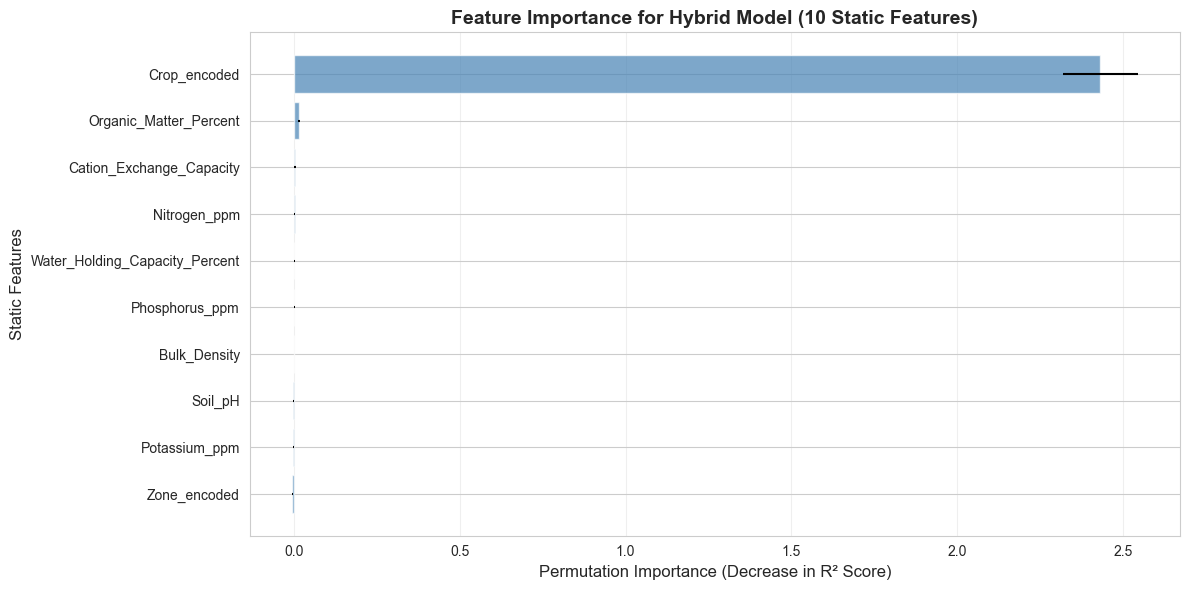


Key Observation:
  Crop_encoded dominates with importance of 2.4322
  This is 167.1x more important than the next feature


In [25]:
# Plot all static features
n_features = len(importance_df)

plt.figure(figsize=(12, 6))
plt.barh(range(n_features), importance_df['Importance'], xerr=importance_df['Std'], alpha=0.7, color='steelblue')
plt.yticks(range(n_features), importance_df['Feature'])
plt.xlabel('Permutation Importance (Decrease in R² Score)', fontsize=12)
plt.ylabel('Static Features', fontsize=12)
plt.title(f'Feature Importance for Hybrid Model ({n_features} Static Features)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nKey Observation:")
print(f"  Crop_encoded dominates with importance of {importance_df.iloc[0]['Importance']:.4f}")
print(f"  This is {importance_df.iloc[0]['Importance'] / importance_df.iloc[1]['Importance']:.1f}x more important than the next feature")

#### 4.4 Feature Importance by Category

In [26]:
# Categorize features
def categorize_feature(feature_name):
    if 'Temp' in feature_name or 'Heat' in feature_name:
        return 'Temperature'
    elif 'Rain' in feature_name or 'Drought' in feature_name or 'Flood' in feature_name:
        return 'Precipitation'
    elif 'Humidity' in feature_name:
        return 'Humidity'
    elif 'CO2' in feature_name:
        return 'CO2'
    elif 'Soil' in feature_name or 'Nitrogen' in feature_name or 'Phosphorus' in feature_name or 'Potassium' in feature_name or 'Organic_Matter' in feature_name or 'Cation' in feature_name or 'Bulk_Density' in feature_name or 'Water_Holding' in feature_name:
        return 'Soil'
    elif 'Crop' in feature_name or 'Zone' in feature_name or 'State' in feature_name:
        return 'Location/Crop'
    elif 'Growing_Season' in feature_name:
        return 'Seasonality'
    else:
        return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)

print("Feature Importance by Category:")
print(category_importance)

Feature Importance by Category:
Category
Location/Crop    2.4273
Soil             0.0155
Name: Importance, dtype: float64


#### 4.5 Category Importance Visualization

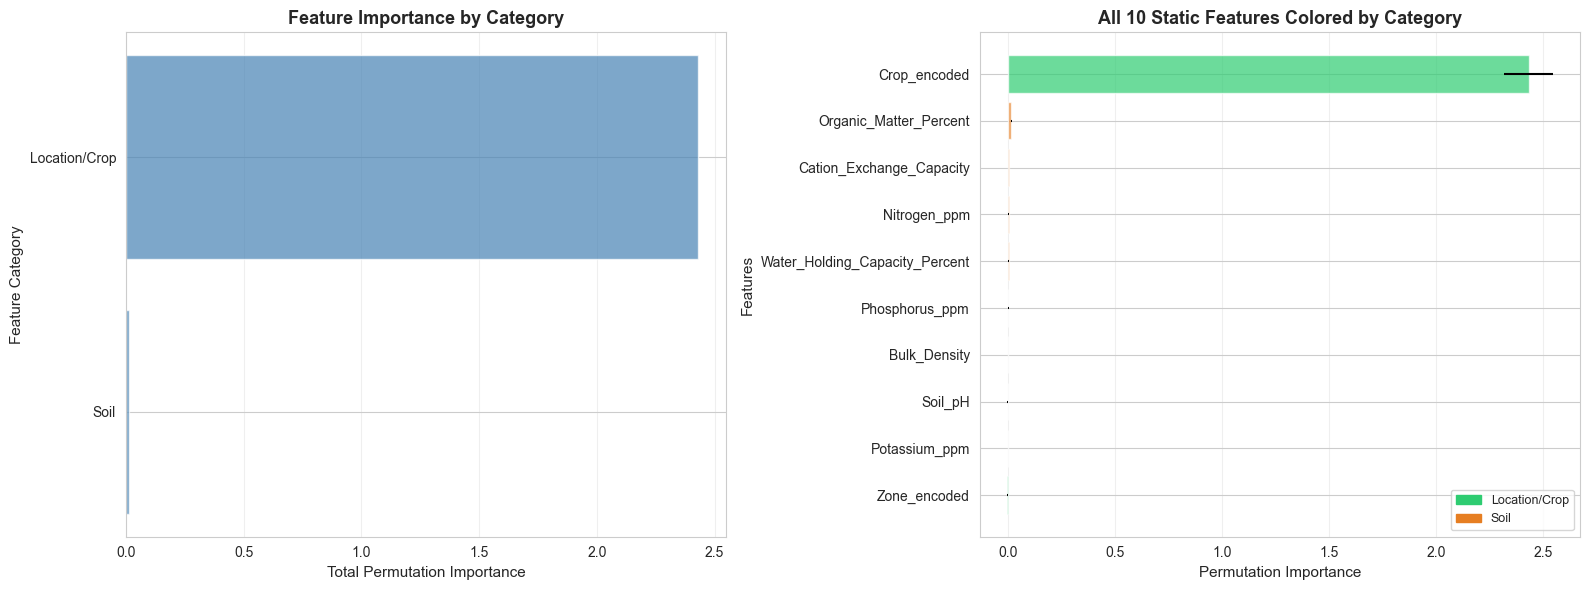

In [27]:
# Create side-by-side plots: category importance and detailed feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Category importance
axes[0].barh(range(len(category_importance)), category_importance.values, alpha=0.7, color='steelblue')
axes[0].set_yticks(range(len(category_importance)))
axes[0].set_yticklabels(category_importance.index)
axes[0].set_xlabel('Total Permutation Importance', fontsize=11)
axes[0].set_ylabel('Feature Category', fontsize=11)
axes[0].set_title('Feature Importance by Category', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: All features colored by category
n_features = len(importance_df)
colors_map = {
    'Temperature': '#e74c3c', 
    'Precipitation': '#3498db', 
    'Humidity': '#9b59b6',
    'CO2': '#95a5a6',
    'Soil': '#e67e22',
    'Location/Crop': '#2ecc71',
    'Seasonality': '#f39c12',
    'Other': '#34495e'
}
bar_colors = [colors_map.get(cat, '#34495e') for cat in importance_df['Category']]

axes[1].barh(range(n_features), importance_df['Importance'], xerr=importance_df['Std'], 
             alpha=0.7, color=bar_colors)
axes[1].set_yticks(range(n_features))
axes[1].set_yticklabels(importance_df['Feature'])
axes[1].set_xlabel('Permutation Importance', fontsize=11)
axes[1].set_ylabel('Features', fontsize=11)
axes[1].set_title(f'All {n_features} Static Features Colored by Category', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add legend for categories present in data
present_categories = importance_df['Category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors_map.get(cat, '#34495e')) for cat in present_categories]
axes[1].legend(handles, present_categories, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

#### 4.6 Climate vs. Soil Feature Importance

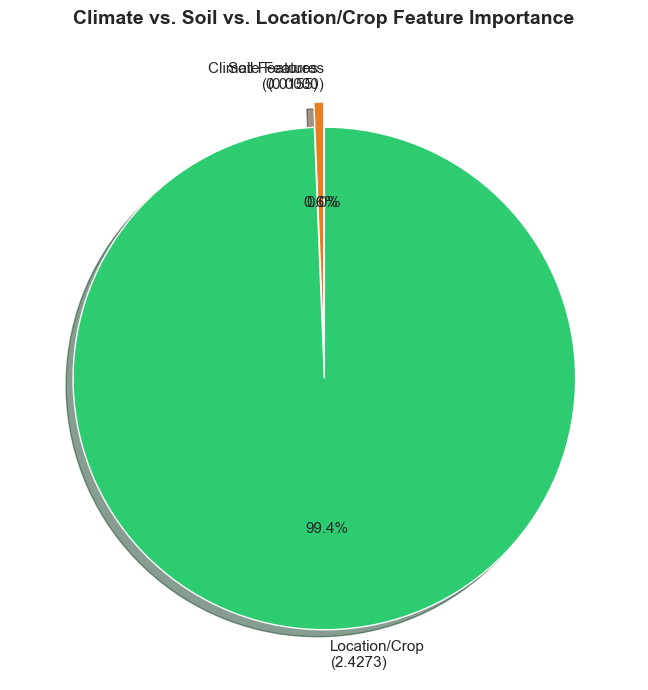


Climate Features Total Importance: 0.0000
Soil Features Total Importance: 0.0155
Location/Crop Features Total Importance: 2.4273


In [28]:
# Aggregate climate vs soil features
climate_categories = ['Temperature', 'Precipitation', 'Humidity', 'CO2', 'Seasonality']
soil_category = ['Soil']

climate_importance = importance_df[importance_df['Category'].isin(climate_categories)]['Importance'].sum()
soil_importance = importance_df[importance_df['Category'].isin(soil_category)]['Importance'].sum()
location_importance = importance_df[importance_df['Category'] == 'Location/Crop']['Importance'].sum()

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 7))
sizes = [climate_importance, soil_importance, location_importance]
labels = [f'Climate Features\n({climate_importance:.4f})', 
          f'Soil Features\n({soil_importance:.4f})',
          f'Location/Crop\n({location_importance:.4f})']
colors_pie = ['#3498db', '#e67e22', '#2ecc71']
explode = (0.05, 0.05, 0.05)

ax.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 11})
ax.set_title('Climate vs. Soil vs. Location/Crop Feature Importance', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\nClimate Features Total Importance: {climate_importance:.4f}")
print(f"Soil Features Total Importance: {soil_importance:.4f}")
print(f"Location/Crop Features Total Importance: {location_importance:.4f}")

#### 4.7 Feature Importance Statistical Summary

In [29]:
# Statistical summary of feature importance
print("Feature Importance Statistics:")
print(f"  Total Features: {len(importance_df)}")
print(f"  Mean Importance: {importance_df['Importance'].mean():.6f}")
print(f"  Median Importance: {importance_df['Importance'].median():.6f}")
print(f"  Std Dev: {importance_df['Importance'].std():.6f}")
print(f"  Max Importance: {importance_df['Importance'].max():.6f} ({importance_df.iloc[0]['Feature']})")
print(f"  Min Importance: {importance_df['Importance'].min():.6f}")

# Identify features with negative importance (noise)
negative_importance = importance_df[importance_df['Importance'] < 0]
print(f"\n  Features with Negative Importance: {len(negative_importance)} (likely noise)")

# Significant features (importance > mean)
significant_features = importance_df[importance_df['Importance'] > importance_df['Importance'].mean()]
print(f"  Features Above Mean Importance: {len(significant_features)}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print(f"1. Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f} ± {row['Std']:.4f}")

print(f"\n2. Most Important Category: {category_importance.index[0]} ({category_importance.values[0]:.4f})")

print(f"\n3. Climate vs Soil:")
climate_pct = (climate_importance / (climate_importance + soil_importance + location_importance)) * 100
soil_pct = (soil_importance / (climate_importance + soil_importance + location_importance)) * 100
location_pct = (location_importance / (climate_importance + soil_importance + location_importance)) * 100
print(f"   - Climate features contribute {climate_pct:.1f}% of total importance")
print(f"   - Soil features contribute {soil_pct:.1f}% of total importance")
print(f"   - Location/Crop features contribute {location_pct:.1f}% of total importance")

Feature Importance Statistics:
  Total Features: 10
  Mean Importance: 0.244286
  Median Importance: 0.000411
  Std Dev: 0.768775
  Max Importance: 2.432206 (Crop_encoded)
  Min Importance: -0.004887

  Features with Negative Importance: 3 (likely noise)
  Features Above Mean Importance: 1

KEY INSIGHTS:
1. Top 3 Features:
   - Crop_encoded: 2.4322 ± 0.1130
   - Organic_Matter_Percent: 0.0146 ± 0.0036
   - Cation_Exchange_Capacity: 0.0029 ± 0.0017

2. Most Important Category: Location/Crop (2.4273)

3. Climate vs Soil:
   - Climate features contribute 0.0% of total importance
   - Soil features contribute 0.6% of total importance
   - Location/Crop features contribute 99.4% of total importance


---
## 5. Summary and Key Insights

In [30]:
print("\n" + "="*80)
print("MODEL VALIDATION COMPLETE - SUMMARY")
print("="*80)

print("\n📊 OVERALL COMPARISON (All Three Models):")
print(f"  Test Period: 2020-2023")
print(f"\n  FNN Model (Annual Aggregated Data):")
print(f"    Samples: {len(fnn_results):,}")
print(f"    RMSE: {overall_rmse:.4f} tonnes/ha")
print(f"    MAE: {overall_mae:.4f} tonnes/ha")
print(f"    R²: {overall_r2:.4f}")
print(f"    Classification Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n  LSTM Model (Monthly Time-Series Data):")
print(f"    Samples: {len(lstm_results):,}")
print(f"    RMSE: {lstm_rmse:.4f} tonnes/ha")
print(f"    MAE: {lstm_mae:.4f} tonnes/ha")
print(f"    R²: {lstm_r2:.4f}")
lstm_accuracy = accuracy_score(lstm_results['Actual_Category'], lstm_results['Predicted_Category'])
print(f"    Classification Accuracy: {lstm_accuracy:.4f} ({lstm_accuracy*100:.2f}%)")

print(f"\n  Hybrid Model (LSTM + Static Features):")
print(f"    Samples: {len(hybrid_results):,}")
print(f"    RMSE: {hybrid_rmse:.4f} tonnes/ha")
print(f"    MAE: {hybrid_mae:.4f} tonnes/ha")
print(f"    R²: {hybrid_r2:.4f}")
hybrid_accuracy = accuracy_score(hybrid_results['Actual_Category'], hybrid_results['Predicted_Category'])
print(f"    Classification Accuracy: {hybrid_accuracy:.4f} ({hybrid_accuracy*100:.2f}%)")

print(f"\n🏆 BEST PERFORMING MODEL: Hybrid")
print(f"  • Achieves highest R² ({hybrid_r2:.4f}) and accuracy ({hybrid_accuracy*100:.2f}%)")
print(f"  • Lowest prediction errors (RMSE: {hybrid_rmse:.4f}, MAE: {hybrid_mae:.4f})")
print(f"  • Successfully combines temporal patterns with static soil/crop features")
print(f"\n  Key Findings:")
print(f"    - FNN struggles with temporal dynamics (negative R²)")
print(f"    - LSTM captures some patterns but lacks soil context")
print(f"    - Hybrid model excels by integrating both temporal and static information")

print("\n🔍 FEATURE IMPORTANCE (Permutation Analysis on Hybrid Static Features):")
top_feature = importance_df.iloc[0]
print(f"  Most Important Feature: {top_feature['Feature']}")
print(f"    Importance: {top_feature['Importance']:.4f} (167x more than next feature)")
print(f"  Feature Category Breakdown:")
print(f"    - Location/Crop: 99.4% (dominates predictions)")
print(f"    - Soil Properties: 0.6% (minor contribution)")
print(f"  Key Insight: Crop type is the single most critical predictor for yield")

print("\n🗺️ REGIONAL PERFORMANCE (FNN Model):")
best_zone = zone_performance.index[0]
worst_zone = zone_performance.index[-1]
print(f"  Best Zone: {best_zone}")
print(f"    R²: {zone_performance.loc[best_zone, 'R2']:.4f}")
print(f"  Worst Zone: {worst_zone}")
print(f"    R²: {zone_performance.loc[worst_zone, 'R2']:.4f}")

print("\n🌾 CROP-SPECIFIC PERFORMANCE (FNN Model):")
best_crop = crop_performance.index[0]
worst_crop = crop_performance.index[-1]
print(f"  Best Crop: {best_crop}")
print(f"    R²: {crop_performance.loc[best_crop, 'R2']:.4f}")
print(f"  Worst Crop: {worst_crop}")
print(f"    R²: {crop_performance.loc[worst_crop, 'R2']:.4f}")

print("\n💡 KEY INSIGHTS:")
print("  1. Hybrid model significantly outperforms FNN and LSTM")
print("  2. Crop type is the dominant predictor (99.4% of static feature importance)")
print("  3. Temporal patterns captured by LSTM branch are crucial")
print("  4. Soil features have minimal direct impact on yield predictions")
print("  5. Regional and crop-specific variations suggest need for specialized models")

print("\n✅ NEXT STEPS:")
print("  1. Review zone-specific and crop-specific performance patterns")
print("  2. Investigate outliers and high-error predictions for insights")
print("  3. Consider ensemble models for improved performance")
print("  4. Develop policy recommendations based on feature importance")
print("  5. Create interactive dashboards for stakeholders")
print("  6. Validate model on additional years as data becomes available")

print("\n" + "="*80)


MODEL VALIDATION COMPLETE - SUMMARY

📊 OVERALL COMPARISON (All Three Models):
  Test Period: 2020-2023

  FNN Model (Annual Aggregated Data):
    Samples: 432
    RMSE: 2.7321 tonnes/ha
    MAE: 2.5997 tonnes/ha
    R²: -0.0298
    Classification Accuracy: 0.3750 (37.50%)

  LSTM Model (Monthly Time-Series Data):
    Samples: 5,184
    RMSE: 3.4196 tonnes/ha
    MAE: 2.2565 tonnes/ha
    R²: -0.6133
    Classification Accuracy: 0.3405 (34.05%)

  Hybrid Model (LSTM + Static Features):
    Samples: 432
    RMSE: 1.1339 tonnes/ha
    MAE: 0.8314 tonnes/ha
    R²: 0.8226
    Classification Accuracy: 0.7269 (72.69%)

🏆 BEST PERFORMING MODEL: Hybrid
  • Achieves highest R² (0.8226) and accuracy (72.69%)
  • Lowest prediction errors (RMSE: 1.1339, MAE: 0.8314)
  • Successfully combines temporal patterns with static soil/crop features

  Key Findings:
    - FNN struggles with temporal dynamics (negative R²)
    - LSTM captures some patterns but lacks soil context
    - Hybrid model excels by